<a href="https://colab.research.google.com/github/joselvira/BiomecanicaPython/blob/master/Notebooks/Como_cortar_variables_ciclicas_en_sus_repeticiones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cómo cortar variables cíclicas en sus repeticiones

Jose Luis López Elvira ([enlace a más recursos en GitHub](https://github.com/joselvira/BiomecanicaPython))

Última modificación 29/08/2021

Una tarea muy frecuente cuando queremos analizar datos en Biomecánica, es descomponer una variable continua que representa varias repeticiones de un movimiento cíclico en sus distintas repeticiones. Esto nos permite representar unas sobre otras y analizarlas conjuntamente, algo que se hace comúnmente para tener una representación promedio del movimiento cíclico.

Algunos ejemplos pueden ser variables obtenidas durante el pedaleo de un ciclista (como el ángulo de rodilla), la aceleración durante la carrera obtenida con un acelerómetro colocado en la zona lumbar, o el momento de fuerza medido con un dinamómetro isocinético durante una prueba que implica varias repeticiones dinamicas.



In [1]:
import numpy as np #tipo de datos Numpy
import pandas as pd #tipo de datos Pandas
import matplotlib.pyplot as plt #librería básica para representar gráficas



Para empezar por un ejemplo sencillo, creamos una onda sinusoidal que puede representar a cualquier variable de un movimiento cíclico continuo. Para hacerlo más interesante (y real), haremos que todas las repeticiones no sean exactamente iguales introduciendo algunas diferencias aleatorias.

Por cierto, puedes consultar otro notebook sobre las características de las señales sinusoidales en [Caracteristicas_de_ondas_sinusoidales](https://github.com/joselvira/BiomecanicaPython/blob/master/Notebooks/Caracteristicas_de_ondas_sinusoidales.ipynb).

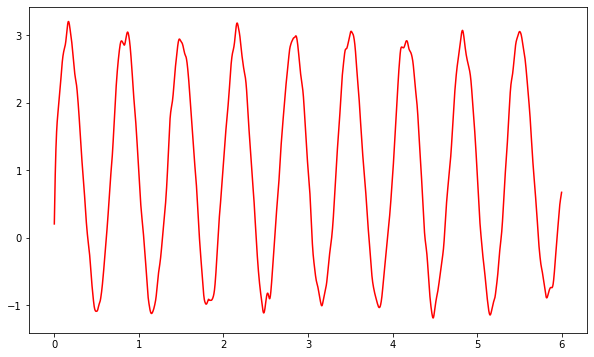

In [2]:
from scipy.signal import butter, filtfilt

np.random.seed(1234) #fija la aleatoriedad para asegurarse la reproducibilidad

#calcula array tiempo
duracion = 6.0 #duración del registro en segundos 
Fs = 1000 #frecuencia de muestreo en hercios
Ts = 1./Fs #intervalo de tiempo entre datos en segundos
t = np.arange(0, duracion, Ts)

#offset vertical
of=-1

#ampitud
a=2

#frecuencia
f=1.5

#ángulo de fase, ángulo al inicio del tiempo
af=0

señal = np.array(of + a*np.sin(2*np.pi*f*t + af))


#Crea un ruido aleatorio controlado y lo filtra
a_err = a*0.5


pasadas = 2.0 #nº de pasadas del filtro adelante y atrás
orden = 2
fc_err = 10
Cf = (2**(1/pasadas)-1)**(1/(2*orden)) #correction factor. Para 2nd order = 0.802 
Wn = 2*fc_err/Fs/Cf
b1, a1 = butter(orden, Wn, btype = 'low')
ruido = filtfilt(b1, a1, np.random.uniform(a-a_err, a+a_err, len(t)))


#La variable se compone de la suma de señal y ruido, para que tenga un aspecto más aleatorio
var = señal + ruido

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(t, var, '-', color= 'r')
plt.show()


## Buscar los cortes

Para cortar el registro completo, necesitamos un criterio de corte que sirva como inicio de cada repetición. Debe ser un criterio objetivo inequívoco, que esté presente en algún instante de cada ciclo del movimiento. Por ejemplo, en el pedaleo podría ser cuando el pedal derecho se encuentre en la posición más alta, o en la carrera cuando el pie entre en contacto con el suelo, etc.

Dentro de la señal, estos eventos se pueden encontrar cuando la señal supera o pasa por debajo de un umbral, o cuando se produce un máximo o un mínimo local.

En el ejemplo de la señal creada anteriormente, imaginemos que cada ciclo comienza cuando se produce un valor máximo. Tendremos que buscar los instantes en los que se producen esos valores máximos y guardarlos en una variable.

Para señales sencillas, podemos utilizar la función *find_peaks* de la librería *Scipy*, que devuelve los índices de los lugares en los que se producen los máximos locales de la señal.

[ 167  794  867 1479 1825 1843 2162 2523 2857 3510 4108 4167 4827 5503
 5874]


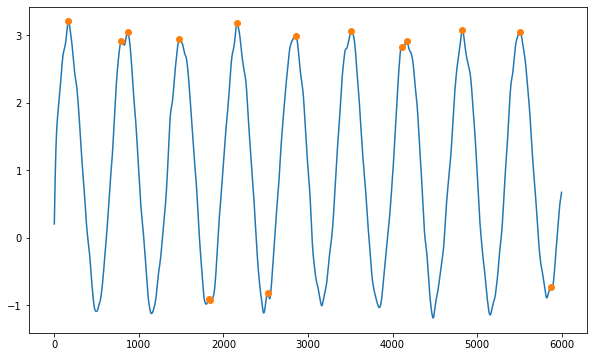

In [3]:
from scipy.signal import find_peaks

maxs, properties = find_peaks(var)
print(maxs)

#Gráfica con la señal y los puntos máximos encontrados.
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(var)
plt.plot(maxs, var[maxs], 'o')
plt.show()

Fíjate en que en algunas repeticiones encuentra máximos locales muy próximos unos a otros dentro de la misma repetición. Incluso puede encontrar un máximo en un lugar cercano a un valle, porque se produce algún repunte en la señal. Estos problemas son frecuentes en señales reales, por eso la función *find_peaks* tiene algunos parámetros para refinar la búsqueda.

Para poder controlar aún más las opciones de búsqueda, vamos a utilizar otra opción, que es la librería creada por Marcos Duarte que se llama [*Detecta*](https://pypi.org/project/detecta/), que tiene funciones muy flexibles no solo para encontrar los máximos y mínimos locales, sino también para detectar cuándo se supera un umbral, entre otras. Funciona perfectamente para esas tareas.

Para poder utilizar esta librería es necesario instarla, se hace fácilmente con el siguiente comando.

In [4]:
#Instala la librería detecta (Marcos Duarte)
!pip install detecta

from detecta import detect_peaks

Probamos la función con nuestra variable. Fíjate en que tiene incluso una opción para visualizar gráficamente la localización de los eventos que encuentra.

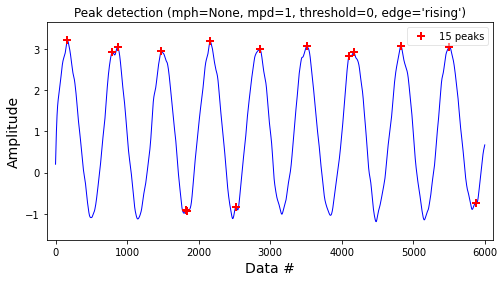

In [5]:
maxs = detect_peaks(var, show=True)

Para evitar los falsos positivos, vamos a perfeccionar la búsqueda introduciendo algunas restricciones. Por ejemplo, cabe esperar que haya un pico cada repetición y no antes, por lo que podemos fijar una distancia mínima desde que encuentra un pico de un número de datos equivalente a la mitad de lo que dura una repetición. En este ejemplo la frecuencia de base de la señal son 1.5 Hz, y la frecuencia de registro son 1000 Hz, por lo que cada ciclo o repetición tiene 1000/1.5 datos, es decir, 666.66 datos. Como la duración de cada ciclo no es exacta, pondremos un valor un poco menor para evitar perder máximos.

Con la instrucción help(detect_peaks) se pueden ver las opciones de la función.

In [6]:
help(detect_peaks)

Help on function detect_peaks in module detecta.detect_peaks:

detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', kpsh=False, valley=False, show=False, ax=None, title=True)
    Detect peaks in data based on their amplitude and other features.
    
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a 

Nos interesa modificar el parámetro *mpd*, que regula el mínimo de datos que deben pasar de un pico a otro. Se puede jugar con los valores hasta encontrar una afinación que funcione para lo que queremos hacer. Como vimos anteriormente, en este caso cada ciclo son unos 666 datos, podríamos poner en torno a la mitad de ese valor. En este caso, poniendo mpd=400 funciona bien para evitar los dobles picos y para evitar también los picos de los valles. Para esto último también podríamos haber fijado una altura mínima de máximo de, por ejemplo, 2 unidades (en el parámetro *mph* de la función), pero como en este ejemplo funciona bien así, lo dejamos.

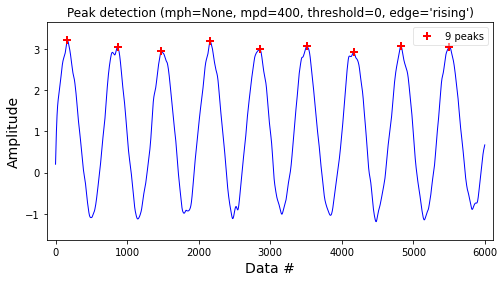

In [7]:
maxs = detect_peaks(var, mpd=400, show=True)

Si quisiéramos detectar los valles, simplemente se debe incluir la instrucción *valley=True* en la función.

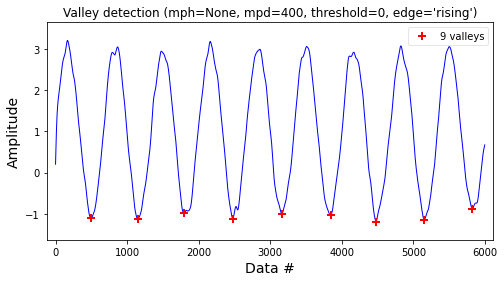

In [8]:
mins = detect_peaks(var, mpd=400, valley=True, show=True)

Para más información sobre los ajustes finos de la función, consulta en la web de la librería [*Detecta*](https://pypi.org/project/detecta/).

Por el momento tenemos un listado de los puntos en los que se completan los ciclos, es decir, el índice del dato cuando cambia de una repetición a otra. Podemos ver los instantes que ha detectado.

In [9]:
maxs

array([ 167,  867, 1479, 2162, 2857, 3510, 4167, 4827, 5503])

## Separar en repeticiones

A continuación, utilizaremos esos puntos de corte para ir metiendo en una lista cada repetición por separado, y después lo juntamos todo en un *dataframe* de *Pandas*.

In [10]:
var_cortes = [] #lista vacía donde iremos incluyendo cada repetición

for corte in range(len(maxs)-1):
  var_cortes.append(var[maxs[corte]:maxs[corte+1]]) #coge el trozo de la variable desde un corte hasta el siguiente

dfVar_cortes = pd.DataFrame(var_cortes).T

dfVar_cortes

,0,1,2,3,4,5,6,7
0,3.206206,3.049284,2.945764,3.182643,2.992897,3.060962,2.920530,3.073903
1,3.205909,3.048836,2.945684,3.182276,2.992504,3.060801,2.920234,3.073377
2,3.204719,3.047732,2.945116,3.181103,2.991503,3.060175,2.919606,3.072026
3,3.202680,3.045993,2.944115,3.179143,2.989857,3.059144,2.918621,3.069857
4,3.199853,3.043634,2.942746,3.176429,2.987548,3.057773,2.917258,3.066892
...,...,...,...,...,...,...,...,...
695,3.041844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
696,3.044546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
697,3.046671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698,3.048187,NaN,NaN,NaN,NaN,NaN,NaN,NaN


El *dataframe* resultante tiene en cada columna una repetición, y en filas los instantes temporales, que manienen la misma frecuencia de registro original.

Podemos representar gráficamente lo que hemos obtenido para ver todas las repeticiones juntas.

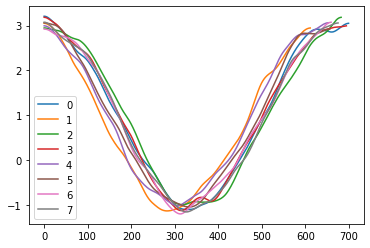

In [11]:
dfVar_cortes.plot()

Una vez tenemos la señal dividida en repeticiones, podríamos por ejemplo normalizar el tiempo, realizar gráficas que representen la media $\pm$ desviación típica (*ensemble average*), etc.